In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import math
from glob import glob
%matplotlib inline

Global seed set to 0


In [76]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [77]:
#load data already subset to 5000 variable features (no batch key added when finding features) with neighbors/umap built from 022222 LinearSCVI model
adata = sc.read_h5ad("/project2/gilad/katie/ebQTL/highpass_combinedFiles/102andPilot_MetaAdded_QCadded_filtered_noNorm_5000VarFeatNoBatchKey_LinearSCVI022222.h5ad")

KeyboardInterrupt: 

In [4]:
obs = adata.obs.reset_index(inplace=False)

In [5]:
obs

cell sample_id Collection.Date  Lane Sample.ID  \
0        ACAGCCGCATCGGATT-13    1008_3       10/8/2020     3  100820_3   
1        CGAAGTTAGTATCTGC-29    1019_1      10/19/2020     1  101920_1   
2        CCACTTGGTACGTAGG-82    1112_5      11/12/2020     5  111220_5   
3        AGATAGAAGACCACGA-59    1102_3       11/2/2020     3  110220_3   
4        AGAGAGCCAGCAGGAT-64    1105_1       11/5/2020     1  110520_1   
...                      ...       ...             ...   ...       ...   
909531   CACGAATAGTATAGGT-99    1209_4       12/9/2020     4  120920_4   
909532    TAACACGAGTTGGACG-3    1001_3       10/1/2020     3  100120_3   
909533   AGACACTCACATATCG-34    1019_6      10/19/2020     6  101920_6   
909534   GCCAGGTGTAATACCC-18    1012_4      10/12/2020     4  101220_4   
909535  TGTGTGACACAAGCTT-102    1214_3      12/14/2020     3  121420_3   

        cDNA.amp.cycles  cDNA.total.yield library.prep.batch Sequencing.batch  \
0                  11.0            543.50                  1                2   
1                  11.0           1416.16                  4                3   
2                  11.0            757.37                  7                9   
3                  11.0           1051.88                  6                6   
4                  11.0           1529.14                  5                7   
...                 ...               ...                ...              ...   
909531             11.0            589.95                  8               10   
909532             11.0            431.63                  1                1   
909533             11.0           3129.98                  4                4   
909534             11.0            364.98                  2                2   
909535             11.0            404.82                  7               10   

       col.group  ...      Z_44      Z_45      Z_46      Z_47      Z_48  \
0         100820  ...  0.669412  1.138793  2.325221  1.762858  0.232308   
1         101920  ...  0.438691  0.140791  0.339563  1.174510 -1.894032   
2         111220  ...  1.039810  0.402693  0.464979 -0.876964  0.297180   
3         110220  ...  0.544481  0.331007 -3.587714 -0.066421  1.993690   
4         110520  ...  0.928700  0.246751 -0.519924 -1.474716  1.881054   
...          ...  ...       ...       ...       ...       ...       ...   
909531    120920  ...  0.076067  1.253338 -0.247005  0.744906 -2.774694   
909532    100120  ...  1.225525  0.739972  1.884845  1.426259  0.139615   
909533    101920  ... -0.145902 -1.900830  0.064899 -0.118360  0.312870   
909534    101220  ...  0.784855 -1.172378 -1.177144 -1.465391  0.069154   
909535    121420  ... -0.334593 -0.102581  1.647311 -0.440830 -1.560663   

            Z_49  leiden_scVI leiden_scVI_0.5  leiden_scVI_0.1      ind_rep  
0       0.346388            2               4                0  NA18502_1.0  
1      -2.067115            1               2                2  NA18520_2.0  
2       0.830566            7               9                0  NA19127_2.0  
3      -0.577363            9               8                3  NA18858_2.0  
4      -0.399786            8               5                5  NA18508_1.0  
...          ...          ...             ...              ...          ...  
909531  0.452314           21               6                0  NA19114_1.0  
909532  0.145320           10               0                0  NA18870_1.0  
909533 -1.503735            8               5                5  NA18856_2.0  
909534  0.721711           28               8                3  NA19210_1.0  
909535 -0.888859            7               9                0  NA19114_2.0  

[909536 rows x 101 columns]

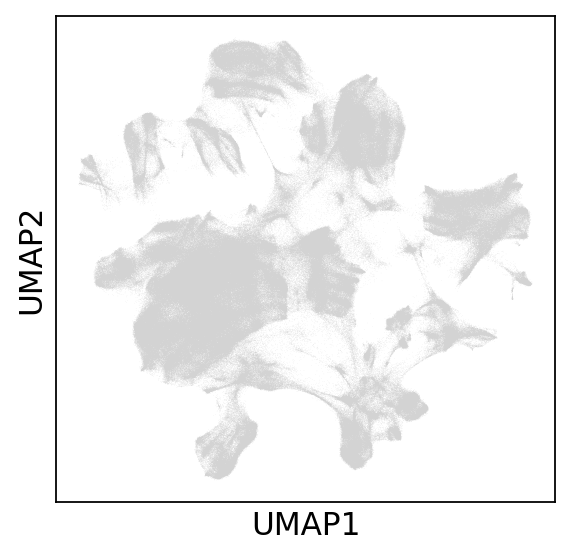

In [6]:
sc.pl.umap(adata)

## Load CellID Annotations

In [7]:
paths = glob('/project2/gilad/ktayeb/ebqtl-workflowr/output/cellid/EB_high_pass_filtered_normalized/by_individual/assignments/txt/*.txt')

In [8]:
def get_cellid_assignments(p, thresh=2):
    celltype_hgt = pd.read_csv(p, index_col=0)
    assignment = celltype_hgt.idxmax(1)
    sig = celltype_hgt.max(1) > 2
    assignment[~sig] = 'Unassigned'
    return assignment
get_sample_id = lambda p: p.split('.')[-3][6:]

cellid_assignments = {get_sample_id(p): get_cellid_assignments(p) for p in paths}
cellid_assignments = pd.concat(cellid_assignments)
cellid_assignments = cellid_assignments.reset_index().rename(
    columns={'level_0':'donor_id', 'level_1':'cell', 0:'cellid_assignment'})

In [9]:
cellid_assignments

donor_id                 cell          cellid_assignment
0       NA18507  AAACCCAAGGTTATAG-36                 Unassigned
1       NA18507  AAACCCACAGGAATCG-36    Trophoblast giant cells
2       NA18507  AAAGAACAGTTCGCAT-36                 Unassigned
3       NA18507  AAAGGATTCCACATAG-36                 Unassigned
4       NA18507  AAAGGTAGTACGGATG-36  Ciliated epithelial cells
...         ...                  ...                        ...
832791  NA18508  TTTGGTTAGATGCCGA-77                 Unassigned
832792  NA18508  TTTGGTTAGATTACCC-77                 Unassigned
832793  NA18508  TTTGGTTCAGGCCCTA-77              Erythroblasts
832794  NA18508  TTTGGTTTCACCACAA-77                 Unassigned
832795  NA18508  TTTGTTGCAACTGTGT-77  Ciliated epithelial cells

[832796 rows x 3 columns]

In [10]:
adata=adata[obs['cell'].isin(cellid_assignments['cell']),:]

In [11]:
adata.obs = pd.merge(adata.obs, cellid_assignments, left_index=True, right_on='cell').set_index('cell')

In [12]:
adata.obs

sample_id Collection.Date  Lane Sample.ID  \
cell                                                             
ACAGCCGCATCGGATT-13     1008_3       10/8/2020     3  100820_3   
CGAAGTTAGTATCTGC-29     1019_1      10/19/2020     1  101920_1   
CCACTTGGTACGTAGG-82     1112_5      11/12/2020     5  111220_5   
AGAGAGCCAGCAGGAT-64     1105_1       11/5/2020     1  110520_1   
TGTCAGAAGTTGCCTA-55     1029_5      10/29/2020     5  102920_5   
...                        ...             ...   ...       ...   
CACGAATAGTATAGGT-99     1209_4       12/9/2020     4  120920_4   
TAACACGAGTTGGACG-3      1001_3       10/1/2020     3  100120_3   
AGACACTCACATATCG-34     1019_6      10/19/2020     6  101920_6   
GCCAGGTGTAATACCC-18     1012_4      10/12/2020     4  101220_4   
TGTGTGACACAAGCTT-102    1214_3      12/14/2020     3  121420_3   

                      cDNA.amp.cycles  cDNA.total.yield library.prep.batch  \
cell                                                                         
ACAGCCGCATCGGATT-13              11.0            543.50                  1   
CGAAGTTAGTATCTGC-29              11.0           1416.16                  4   
CCACTTGGTACGTAGG-82              11.0            757.37                  7   
AGAGAGCCAGCAGGAT-64              11.0           1529.14                  5   
TGTCAGAAGTTGCCTA-55              11.0           1571.42                  5   
...                               ...               ...                ...   
CACGAATAGTATAGGT-99              11.0            589.95                  8   
TAACACGAGTTGGACG-3               11.0            431.63                  1   
AGACACTCACATATCG-34              11.0           3129.98                  4   
GCCAGGTGTAATACCC-18              11.0            364.98                  2   
TGTGTGACACAAGCTT-102             11.0            404.82                  7   

                     Sequencing.batch col.group donor_id_x  ...      Z_46  \
cell                                                        ...             
ACAGCCGCATCGGATT-13                 2    100820    NA18502  ...  2.325221   
CGAAGTTAGTATCTGC-29                 3    101920    NA18520  ...  0.339563   
CCACTTGGTACGTAGG-82                 9    111220    NA19127  ...  0.464979   
AGAGAGCCAGCAGGAT-64                 7    110520    NA18508  ... -0.519924   
TGTCAGAAGTTGCCTA-55                 6    102920    NA19207  ...  0.396429   
...                               ...       ...        ...  ...       ...   
CACGAATAGTATAGGT-99                10    120920    NA19114  ... -0.247005   
TAACACGAGTTGGACG-3                  1    100120    NA18870  ...  1.884845   
AGACACTCACATATCG-34                 4    101920    NA18856  ...  0.064899   
GCCAGGTGTAATACCC-18                 2    101220    NA19210  ... -1.177144   
TGTGTGACACAAGCTT-102               10    121420    NA19114  ...  1.647311   

                          Z_47      Z_48      Z_49 leiden_scVI  \
cell                                                             
ACAGCCGCATCGGATT-13   1.762858  0.232308  0.346388           2   
CGAAGTTAGTATCTGC-29   1.174510 -1.894032 -2.067115           1   
CCACTTGGTACGTAGG-82  -0.876964  0.297180  0.830566           7   
AGAGAGCCAGCAGGAT-64  -1.474716  1.881054 -0.399786           8   
TGTCAGAAGTTGCCTA-55   0.553705  0.079403  1.814933          11   
...                        ...       ...       ...         ...   
CACGAATAGTATAGGT-99   0.744906 -2.774694  0.452314          21   
TAACACGAGTTGGACG-3    1.426259  0.139615  0.145320          10   
AGACACTCACATATCG-34  -0.118360  0.312870 -1.503735           8   
GCCAGGTGTAATACCC-18  -1.465391  0.069154  0.721711          28   
TGTGTGACACAAGCTT-102 -0.440830 -1.560663 -0.888859           7   

                      leiden_scVI_0.5 leiden_scVI_0.1      ind_rep donor_id_y  \
cell                                                                            
ACAGCCGCATCGGATT-13                 4               0  NA18502_1.0    NA18502   
CGAAGTTAGTATCTGC-29                 2      

Cell ID annotated about 39% of cells at p <= 0.01

In [14]:
adata.obs['annotated'] = adata.obs['cellid_assignment'].replace(to_replace={'Unassigned': np.NaN})

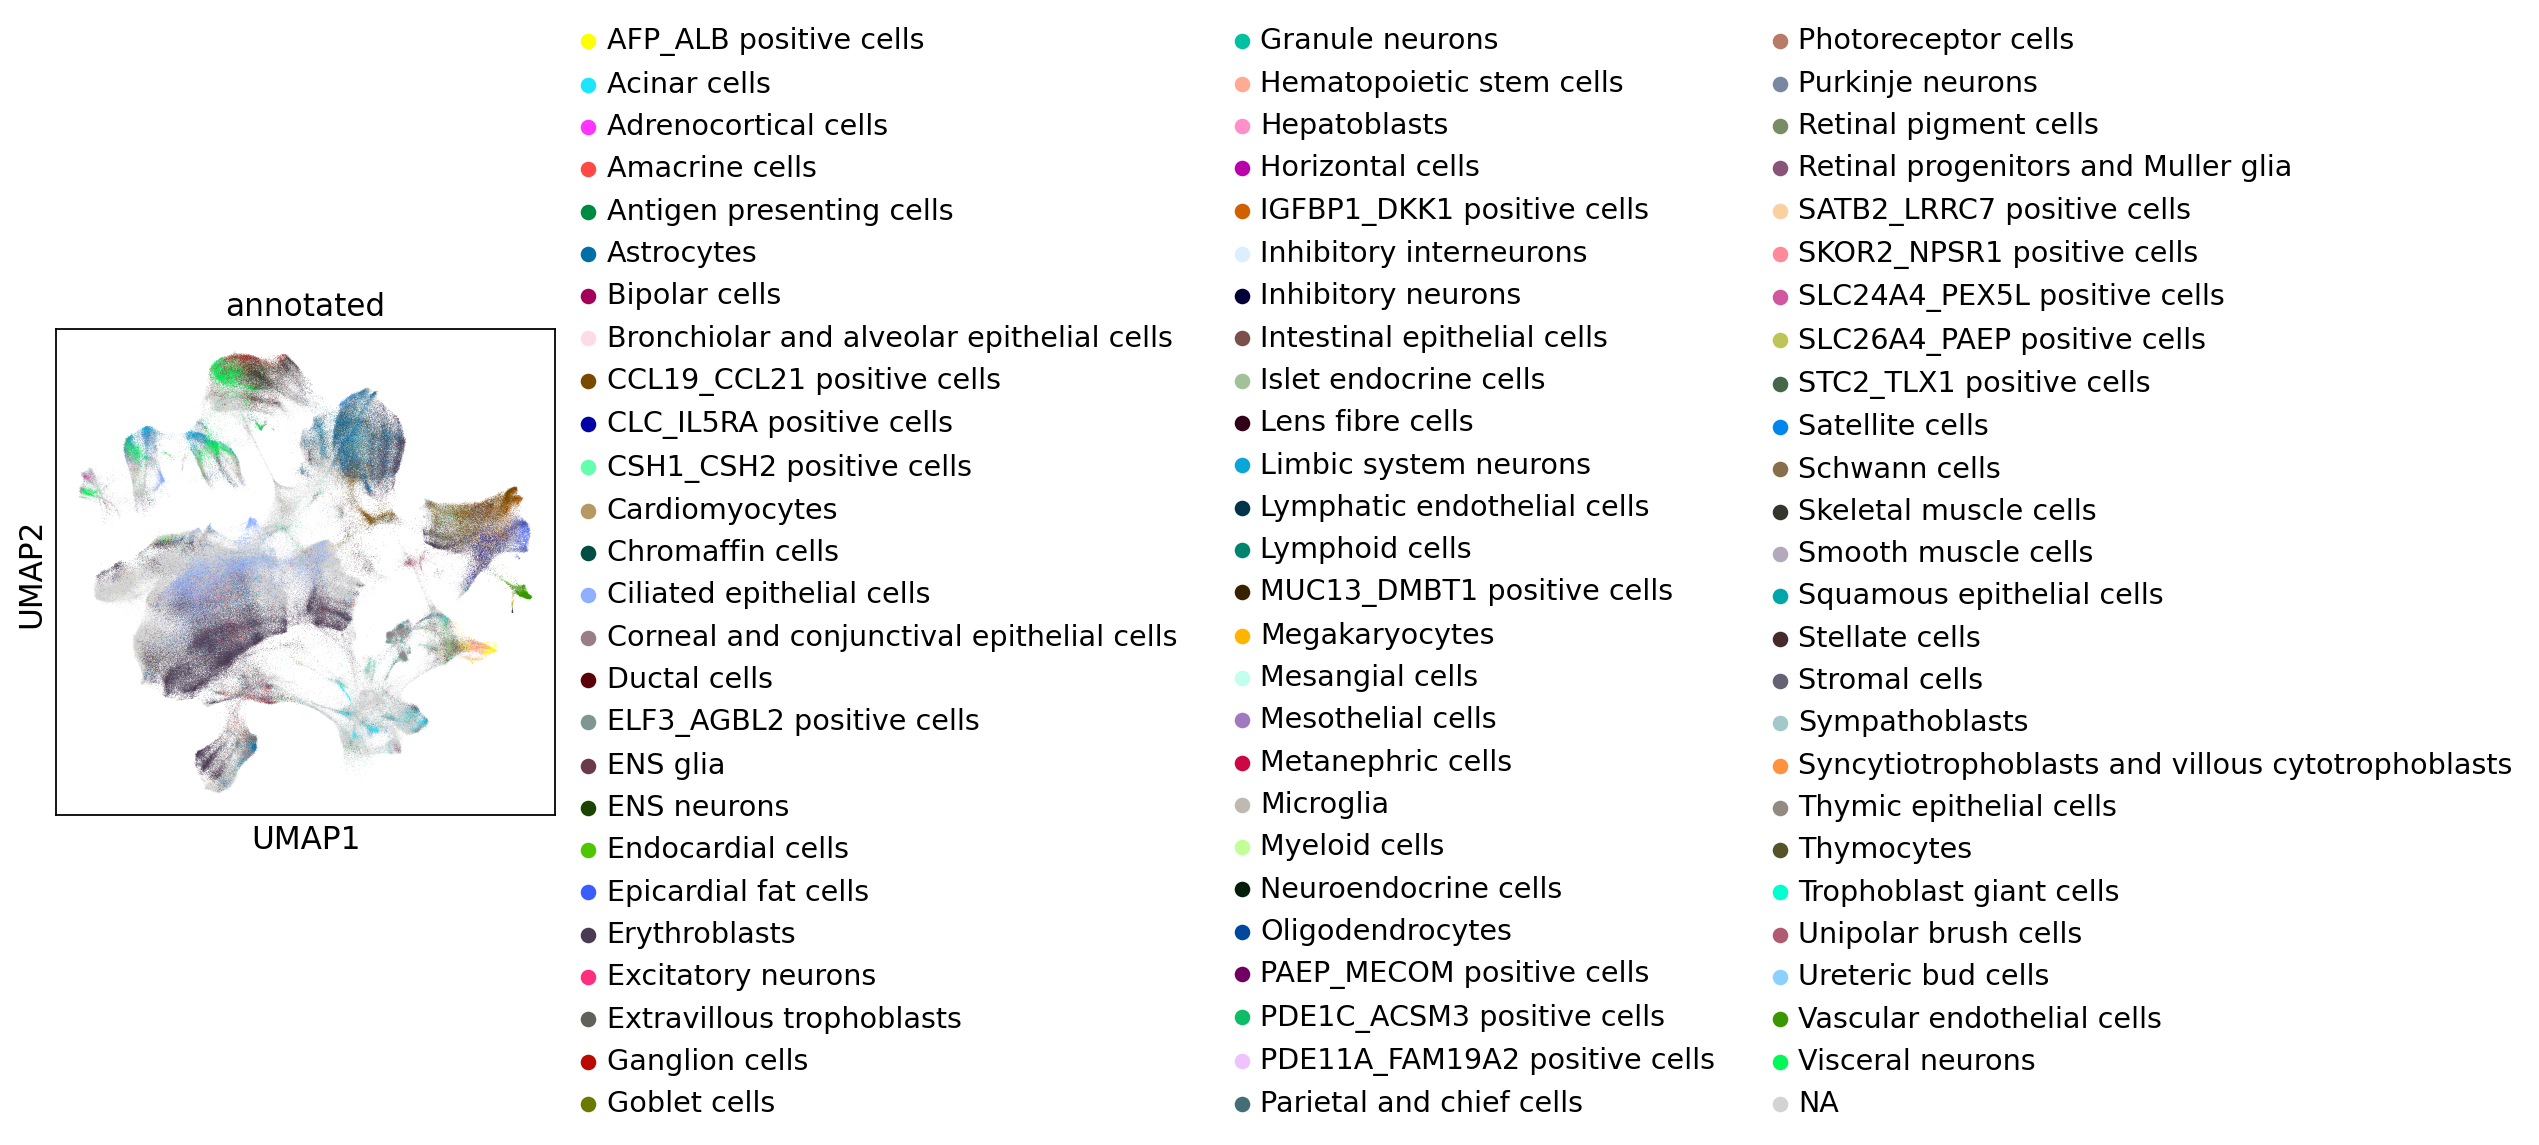

In [15]:
sc.pl.umap(adata, color=['annotated'])

Some of the cellid assignments seem more reliable than others. Specifically, I am more inclined to "believe" the assignments when they lie in the cluster corresponding to the expected germ layer.  So, I'm going to make two annotations for now. 1 just annotating the low resolution clusters by marker genes. Then, a somewhat "higher resolution" version that incorporates some of the more confident cellid assignments. 

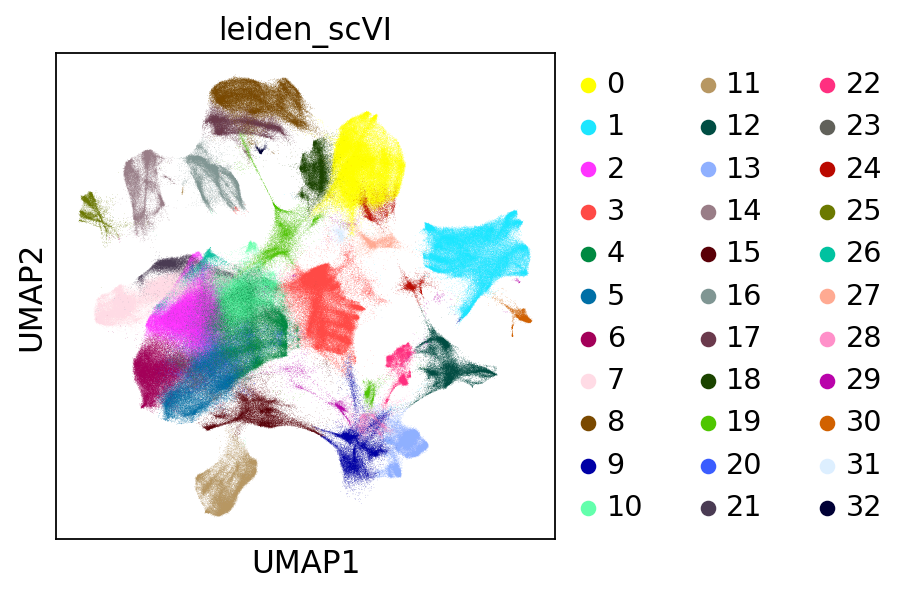

In [16]:
sc.pl.umap(adata, color=["leiden_scVI"])

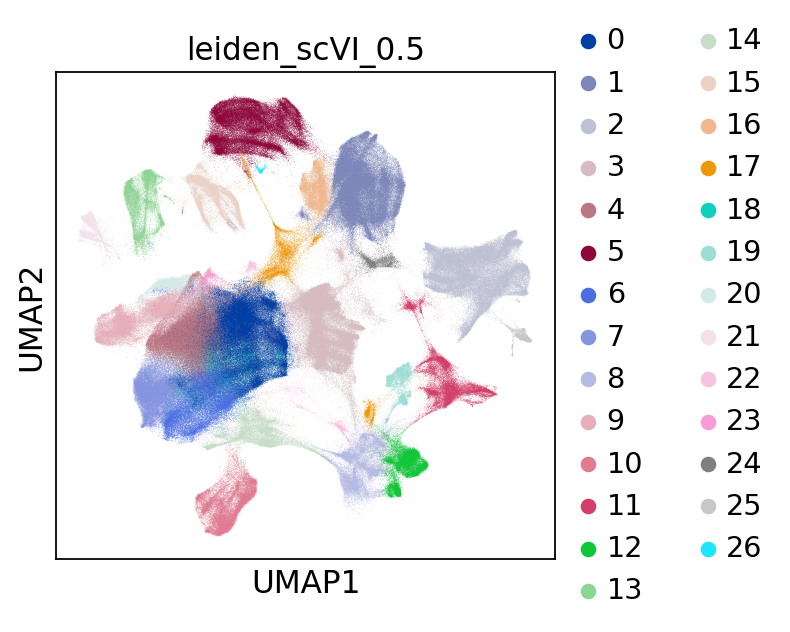

In [17]:
sc.pl.umap(adata, color=["leiden_scVI_0.5"])

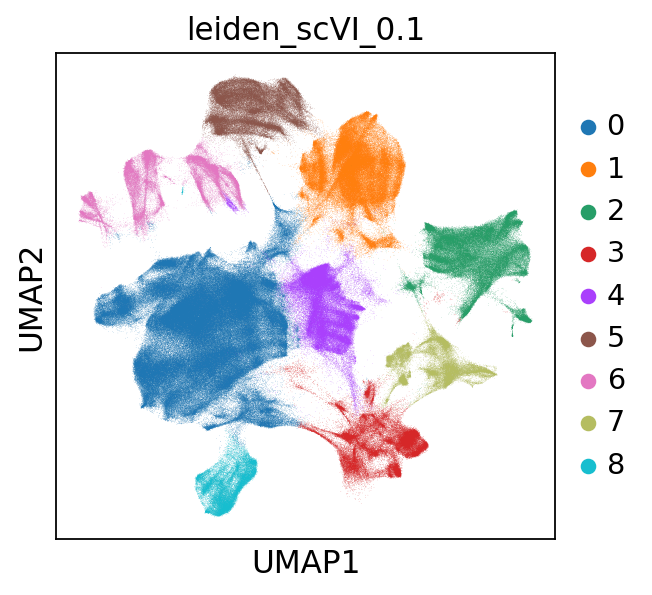

In [18]:
sc.pl.umap(adata, color=["leiden_scVI_0.1"])
#0- early ectoderm/neuroepithilium
#1- neural crest
#2- mesodermEndothelialHematopoetic
#3- pluripotent/undifferentiated
#4- tentative: neural tube
#5- tentative: developing sensory ganglia)
#6- post-mitotic neurons
#7- endoderm (plus maybe trophoblast and/or epithelial cells)
#8- tentative:developing eye (retinal progenitors, retinal pigment cells, photoreceptor cells)

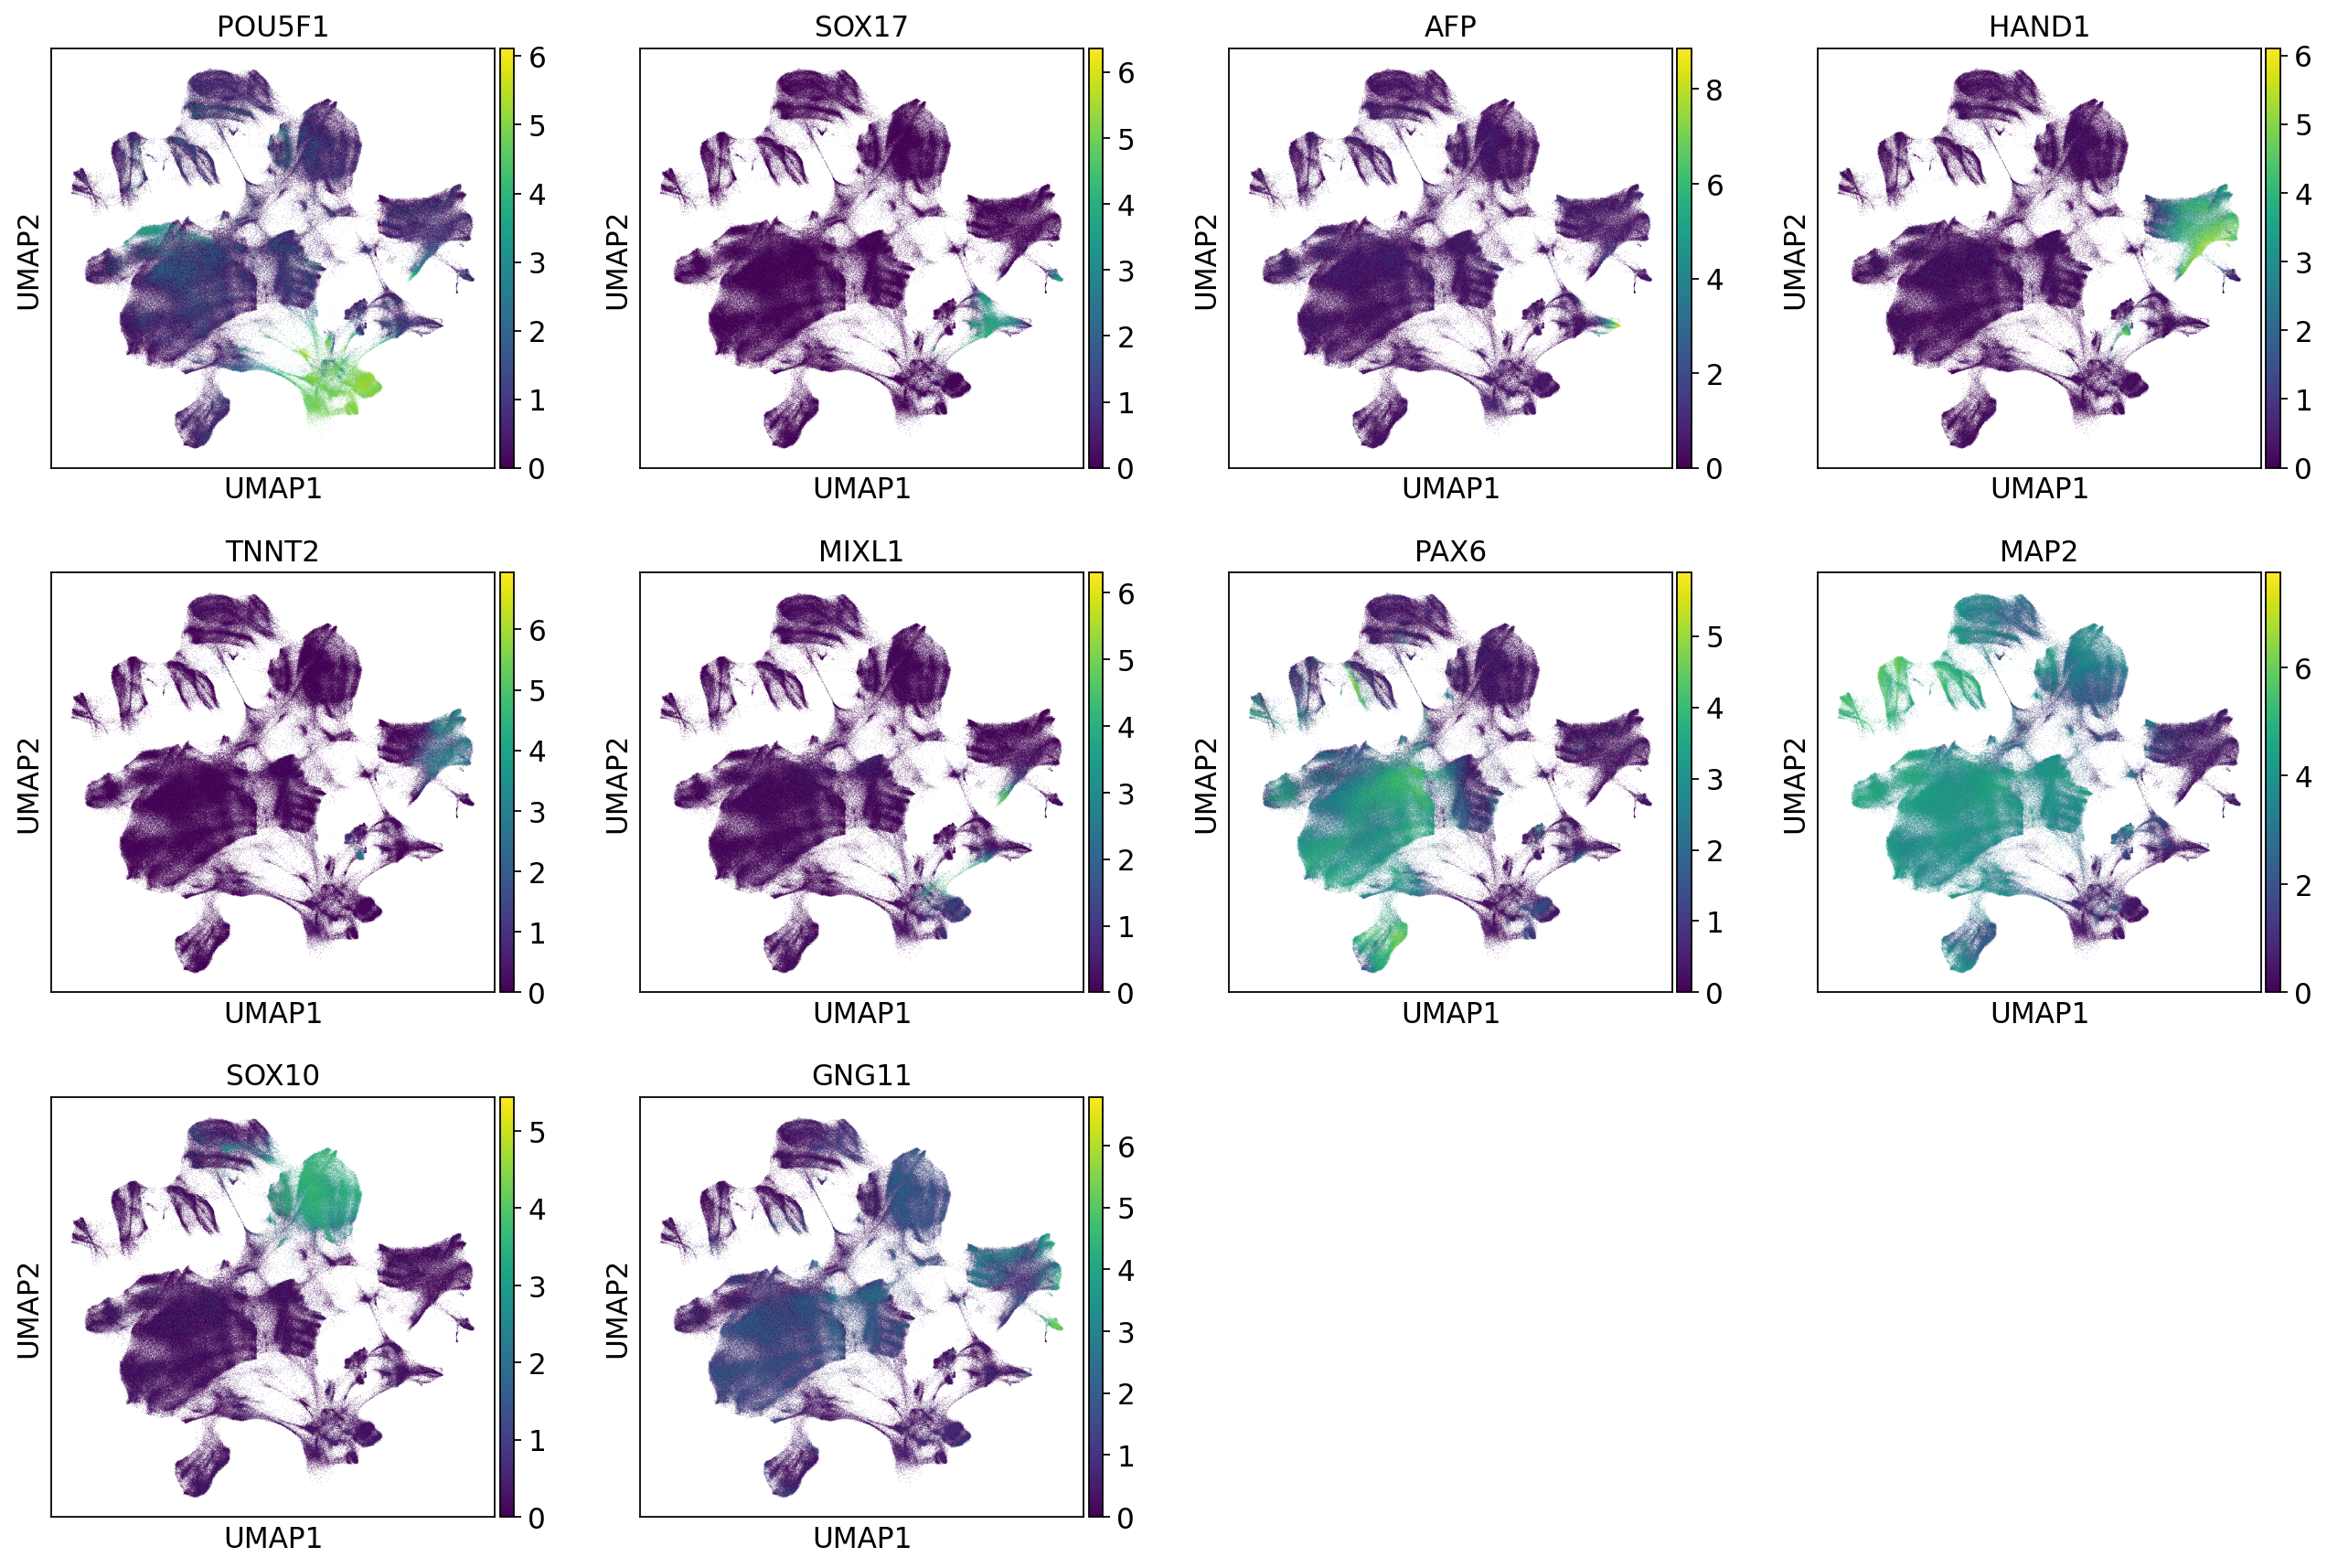

In [19]:
sc.pl.umap(adata, color=["POU5F1", "SOX17", "AFP","HAND1", "TNNT2", "MIXL1", "PAX6", "MAP2", "SOX10", "GNG11"])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:19:42)


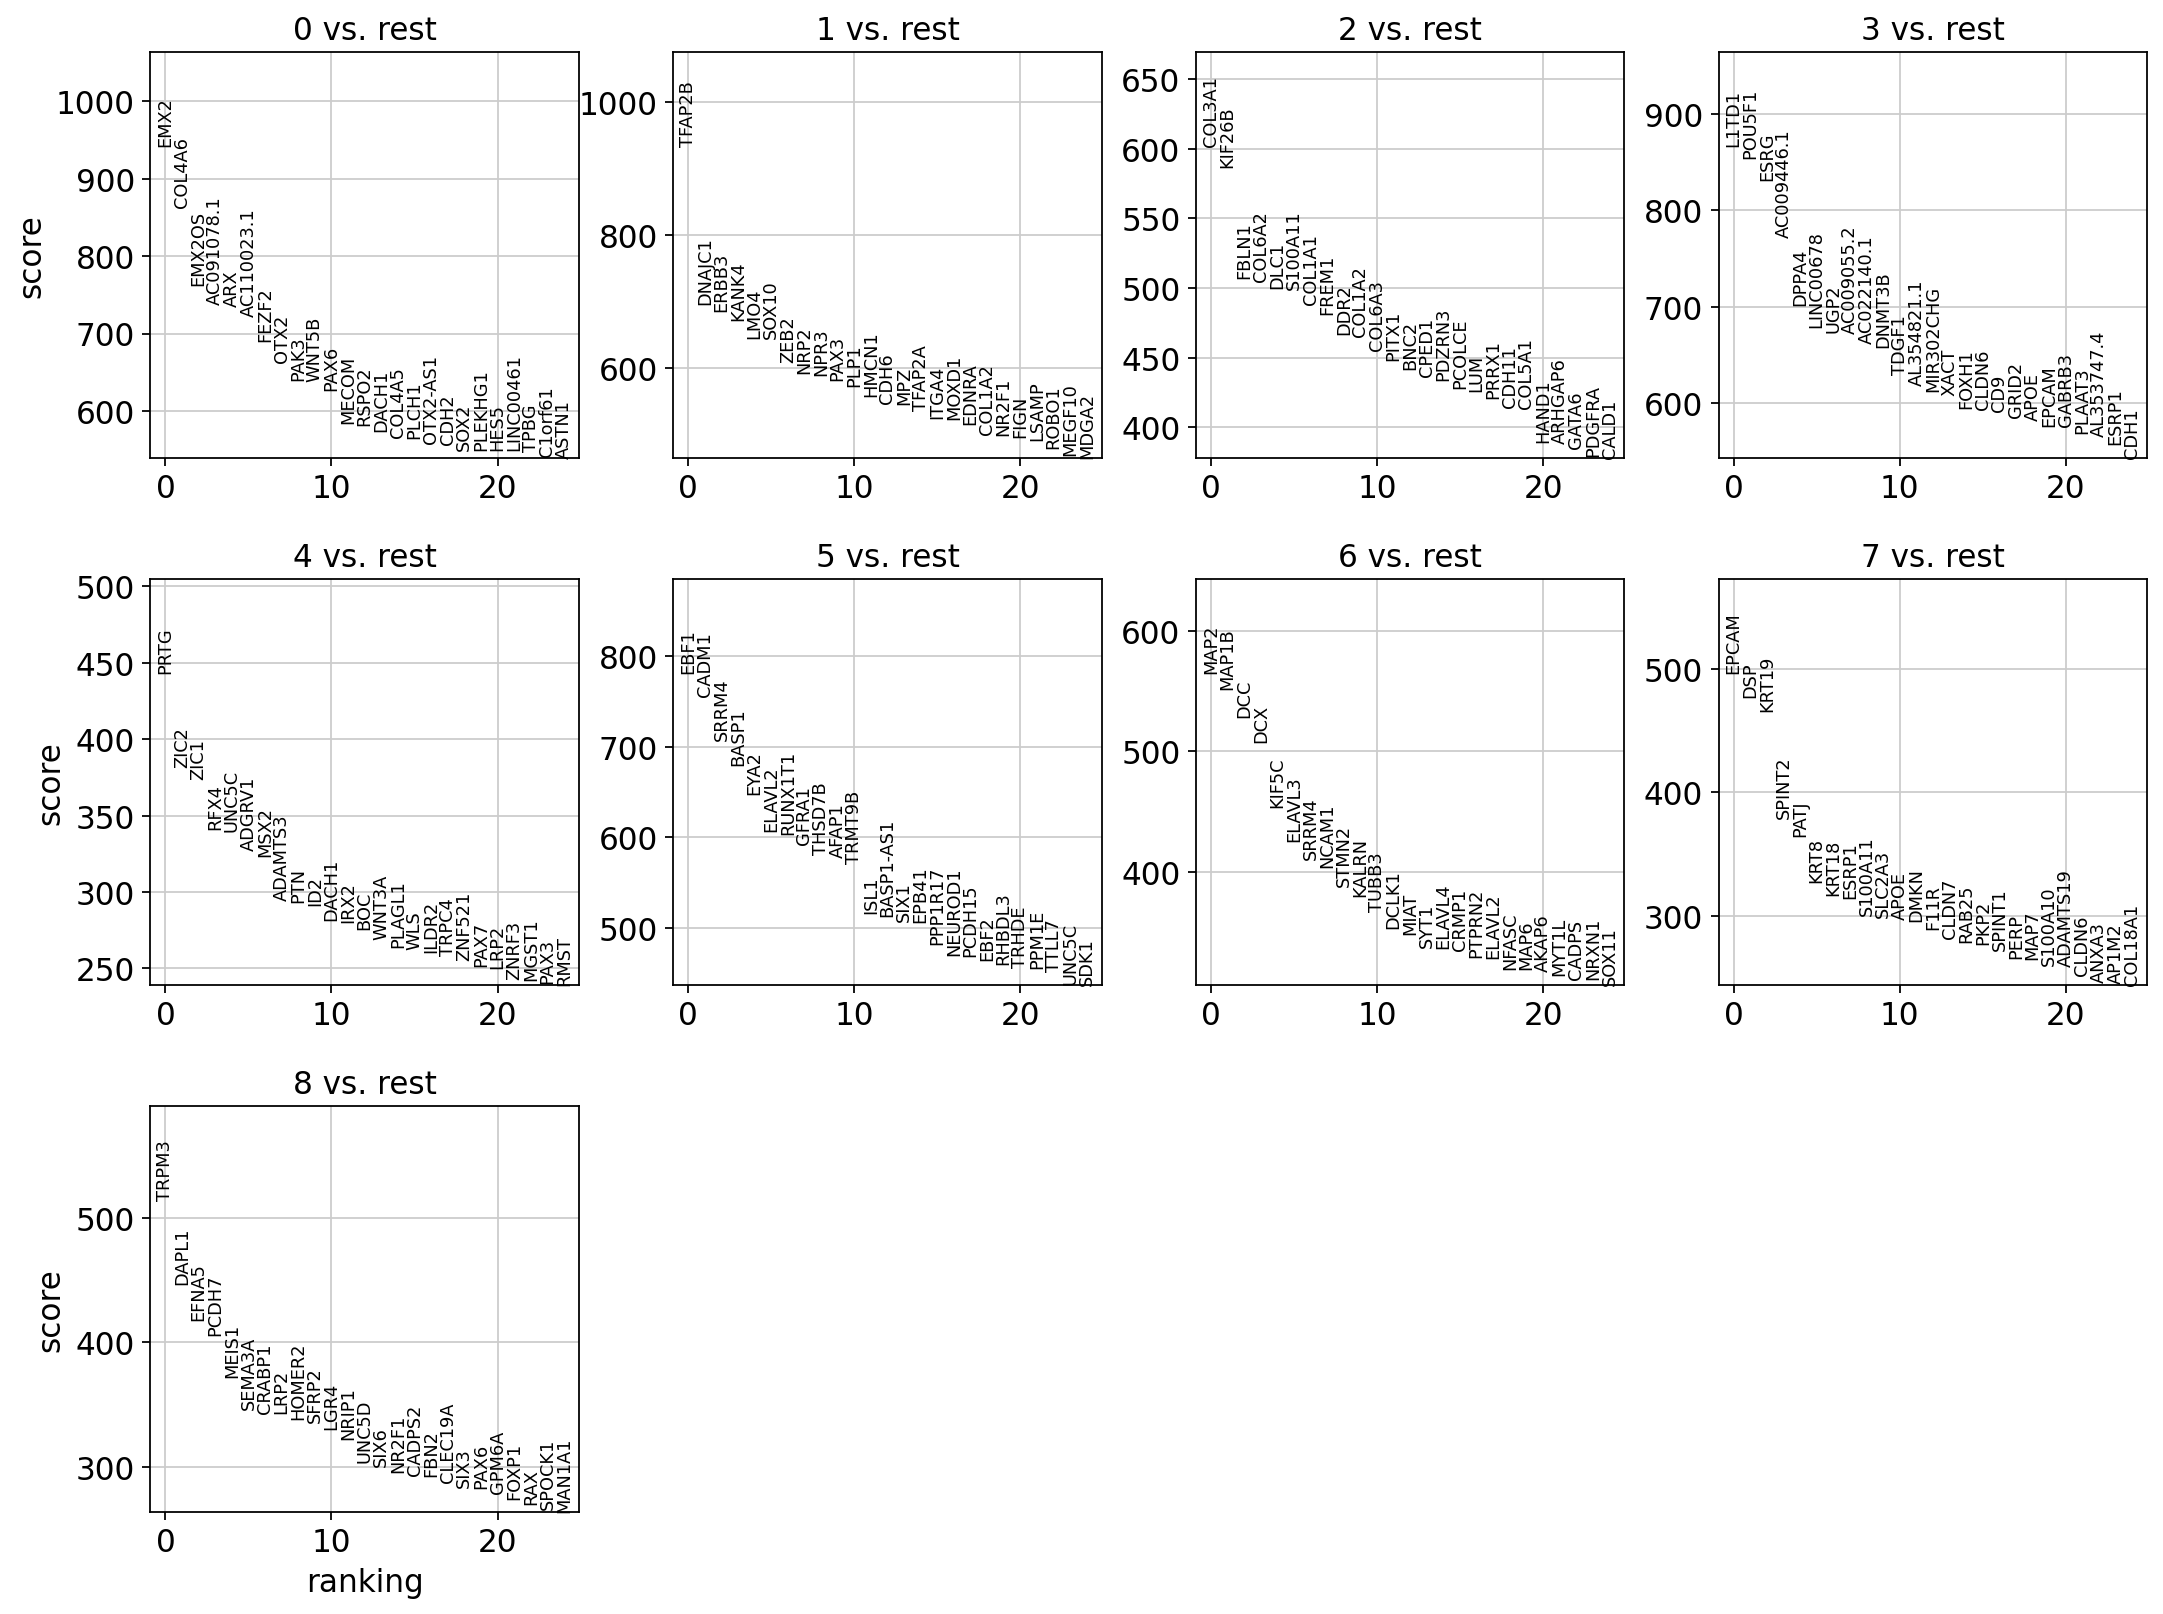

In [24]:
sc.tl.rank_genes_groups(adata, groupby='leiden_scVI_0.1', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

8- TRPM3 in eye development: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7027284/, plus dense eye cell type assignment in that cluster  
4- PRTG high in neural tube: https://pubmed.ncbi.nlm.nih.gov/20335479/. also ZIC2  
5-ISL1 important for development of retinal ganglion cells and overlaps with ganglion cellid annotation.  
ISL1 important for sensory neural dev generallyhttps://www.nature.com/articles/nn.2209  
Neurod1 and ISL1 also both expressed in any developing sensory neurons according to ^  
role for EYA2 in retinal ganglion cell dev https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7014133/  
SIX1 not really expressed in developing retina: https://www.nature.com/articles/s41598-020-69524-8, but SIX6 IS (and SIX6 is marker cluster 8)  

what is the difference between ganglion cells and RETINAL ganglion cells?

In [20]:
adata.obs['leiden_0.1_annotation'] = adata.obs['leiden_scVI_0.1'].replace(to_replace = {'0': 'EarlyEctoderm_neuroepithelium', '1': 'NeuralCrest', '2': 'MesodermEndothelialHematopoetic', '3':'PluripotentUndifferentiated', '4':'tentative_neuralTube', '5':'tentative_DevelopingSensoryGanglia', '6': 'PostMitoticNeurons', '7':'endoderm', '8': 'tentative_developingEye'})

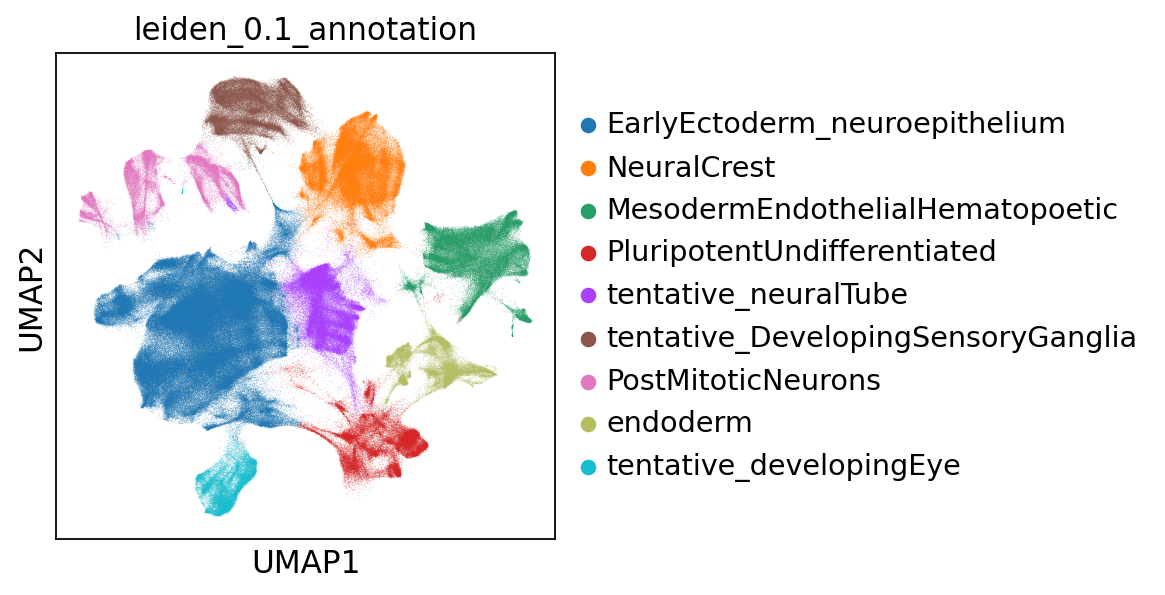

In [25]:
sc.pl.umap(adata, color='leiden_0.1_annotation')

In [22]:
adata.obs['leiden_0.1_germLayer'] = adata.obs['leiden_scVI_0.1'].replace(to_replace = {'0': 'Ectoderm', '1': 'Neural crest', '2': 'Mesoderm', '3':'PluripotentUndifferentiated', '4':'Ectoderm', '5':'Ectoderm', '6': 'Ectoderm', '7':'Endoderm', '8': 'Ectoderm'})

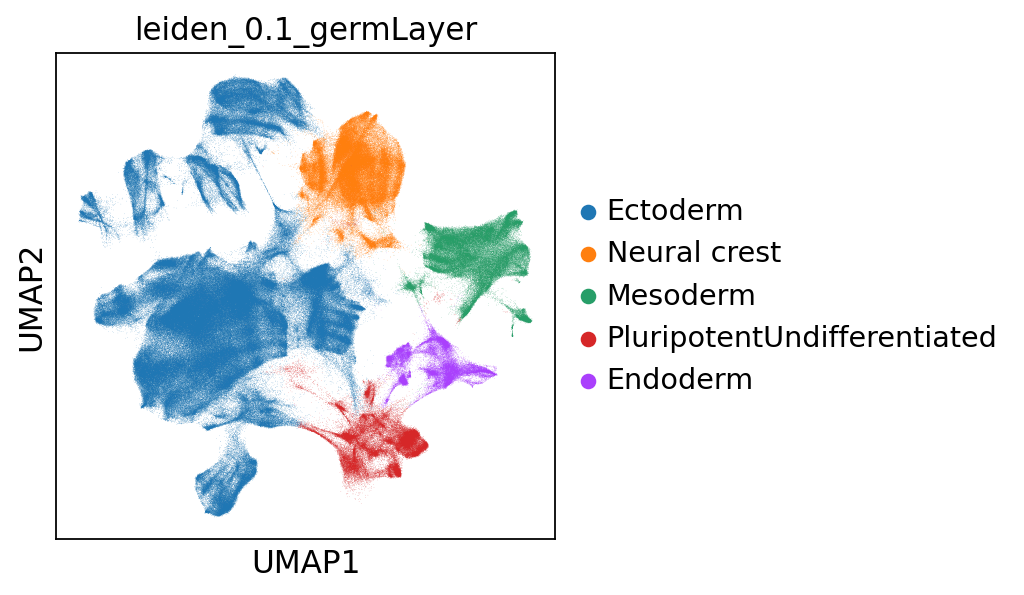

In [26]:
sc.pl.umap(adata, color='leiden_0.1_germLayer')

Now, in cases where cellid annotation matches expected germ layer, keep that annotation. otherwise, use leiden 0.1 annotation. This will still not be perfect (ex: there are erythroblasts annotated that lie in the mesoderm cluster but not with the rest of the hematopoetic cells)

In [23]:
#read in csv with germ layers corresponding to each reference cell type

ref = pd.read_csv("/project2/gilad/katie/ebQTL/FetalReferenceCellTypes_GermLayerAnnotations.csv", header=0)

In [40]:
ref

cell type    Germ layer  \
0                                          Astrocytes  Neural crest   
1                                          Astrocytes      Ectoderm   
2                                           Microglia  Neural crest   
3                                           Microglia      Ectoderm   
4                          CCL19_CCL21 positive cells      Mesoderm   
5                            CLC_IL5RA positive cells      Mesoderm   
6                                       Erythroblasts      Mesoderm   
7                           Ciliated epithelial cells      Endoderm   
8                            Parietal and chief cells      Endoderm   
9                                    Visceral neurons      Ectoderm   
10                                    Mesangial cells      Mesoderm   
11                             AFP_ALB positive cells      Endoderm   
12                                       Acinar cells      Endoderm   
13                                     Amacrine cells      Ectoderm   
14                              Skeletal muscle cells      Mesoderm   
15                               Epicardial fat cells      Mesoderm   
16                                Photoreceptor cells      Ectoderm   
17                                     Ganglion cells      Ectoderm   
18                                   Lens fibre cells      Ectoderm   
19                                   Horizontal cells      Ectoderm   
20                              Limbic system neurons      Ectoderm   
21                                           ENS glia  Neural crest   
22                         Vascular endothelial cells      Mesoderm   
23          Corneal and conjunctival epithelial cells      Ectoderm   
24                                    Satellite cells  Neural crest   
25                                    Satellite cells      Mesoderm   
26                                Smooth muscle cells  Neural crest   
27                                Smooth muscle cells      Mesoderm   
28                              Islet endocrine cells      Endoderm   
29                            Inhibitory interneurons      Ectoderm   
30                          Extravillous trophoblasts      Endoderm   
31                                       Hepatoblasts      Endoderm   
32                            Trophoblast giant cells      Endoderm   
33                         IGFBP1_DKK1 positive cells      Mesoderm   
34                       SLC24A4_PEX5L positive cells      Mesoderm   
35                       SLC24A4_PEX5L positive cells  Neural crest   
36                                   Oligodendrocytes  Neural crest   
37                                   Oligodendrocytes      Ectoderm   
38                                     Lymphoid cells      Mesoderm   
39                                      Bipolar cells      Ectoderm   
40                          Squamous epithelial cells      Endoderm   
41                                 Inhibitory neurons      Ectoderm   
42                                     Cardiomyocytes      Mesoderm   
43                                 Excitatory neurons      Ectoderm   
44                                  Metanephric cells      Mesoderm   
45                           CSH1_CSH2 positive cells  Neural crest   
46                           CSH1_CSH2 positive cells      Mesoderm   
47                           STC2_TLX1 positive cells      Mesoderm   
48                                    Granule neurons      Ectoderm   
49                                  Mesothelial cells      Mesoderm   
50                                   Purkinje neurons      Ectoderm   
51                           Antigen presenting cells      Mesoderm   
52                           Hematopoietic stem cells      Mesoderm   
53                                         Thymocytes      Mesoderm   
54                                       Goblet cells      Endoderm   
55                        Intestinal epithelial cells      Endoderm 

In [51]:
#loop through rows of ref, if germ layer matches leiden_0.1_germLayer and cell type matches "cellid_assignment", then transfer the annotation
adata.obs['cellid_confident'] = adata.obs['leiden_0.1_germLayer']
for r in range(88):
    g = ref['cell type'][r]
    i= ref['Germ layer'][r]
    adata.obs['cellid_confident'] = np.where(((adata.obs['leiden_0.1_germLayer'] == i) & (adata.obs['cellid_assignment'] == g)), g, adata.obs['cellid_confident'])
    
adata.obs['cellid_confident'] = adata.obs['cellid_confident'].replace(to_replace = {'Ectoderm': np.nan, 
                                                                                    'Neural crest': np.nan, 
                                                                                    'Endoderm': np.nan,
                                                                                    'Mesoderm': np.nan,
                                                                                    'PluripotentUndifferentiated': np.nan})

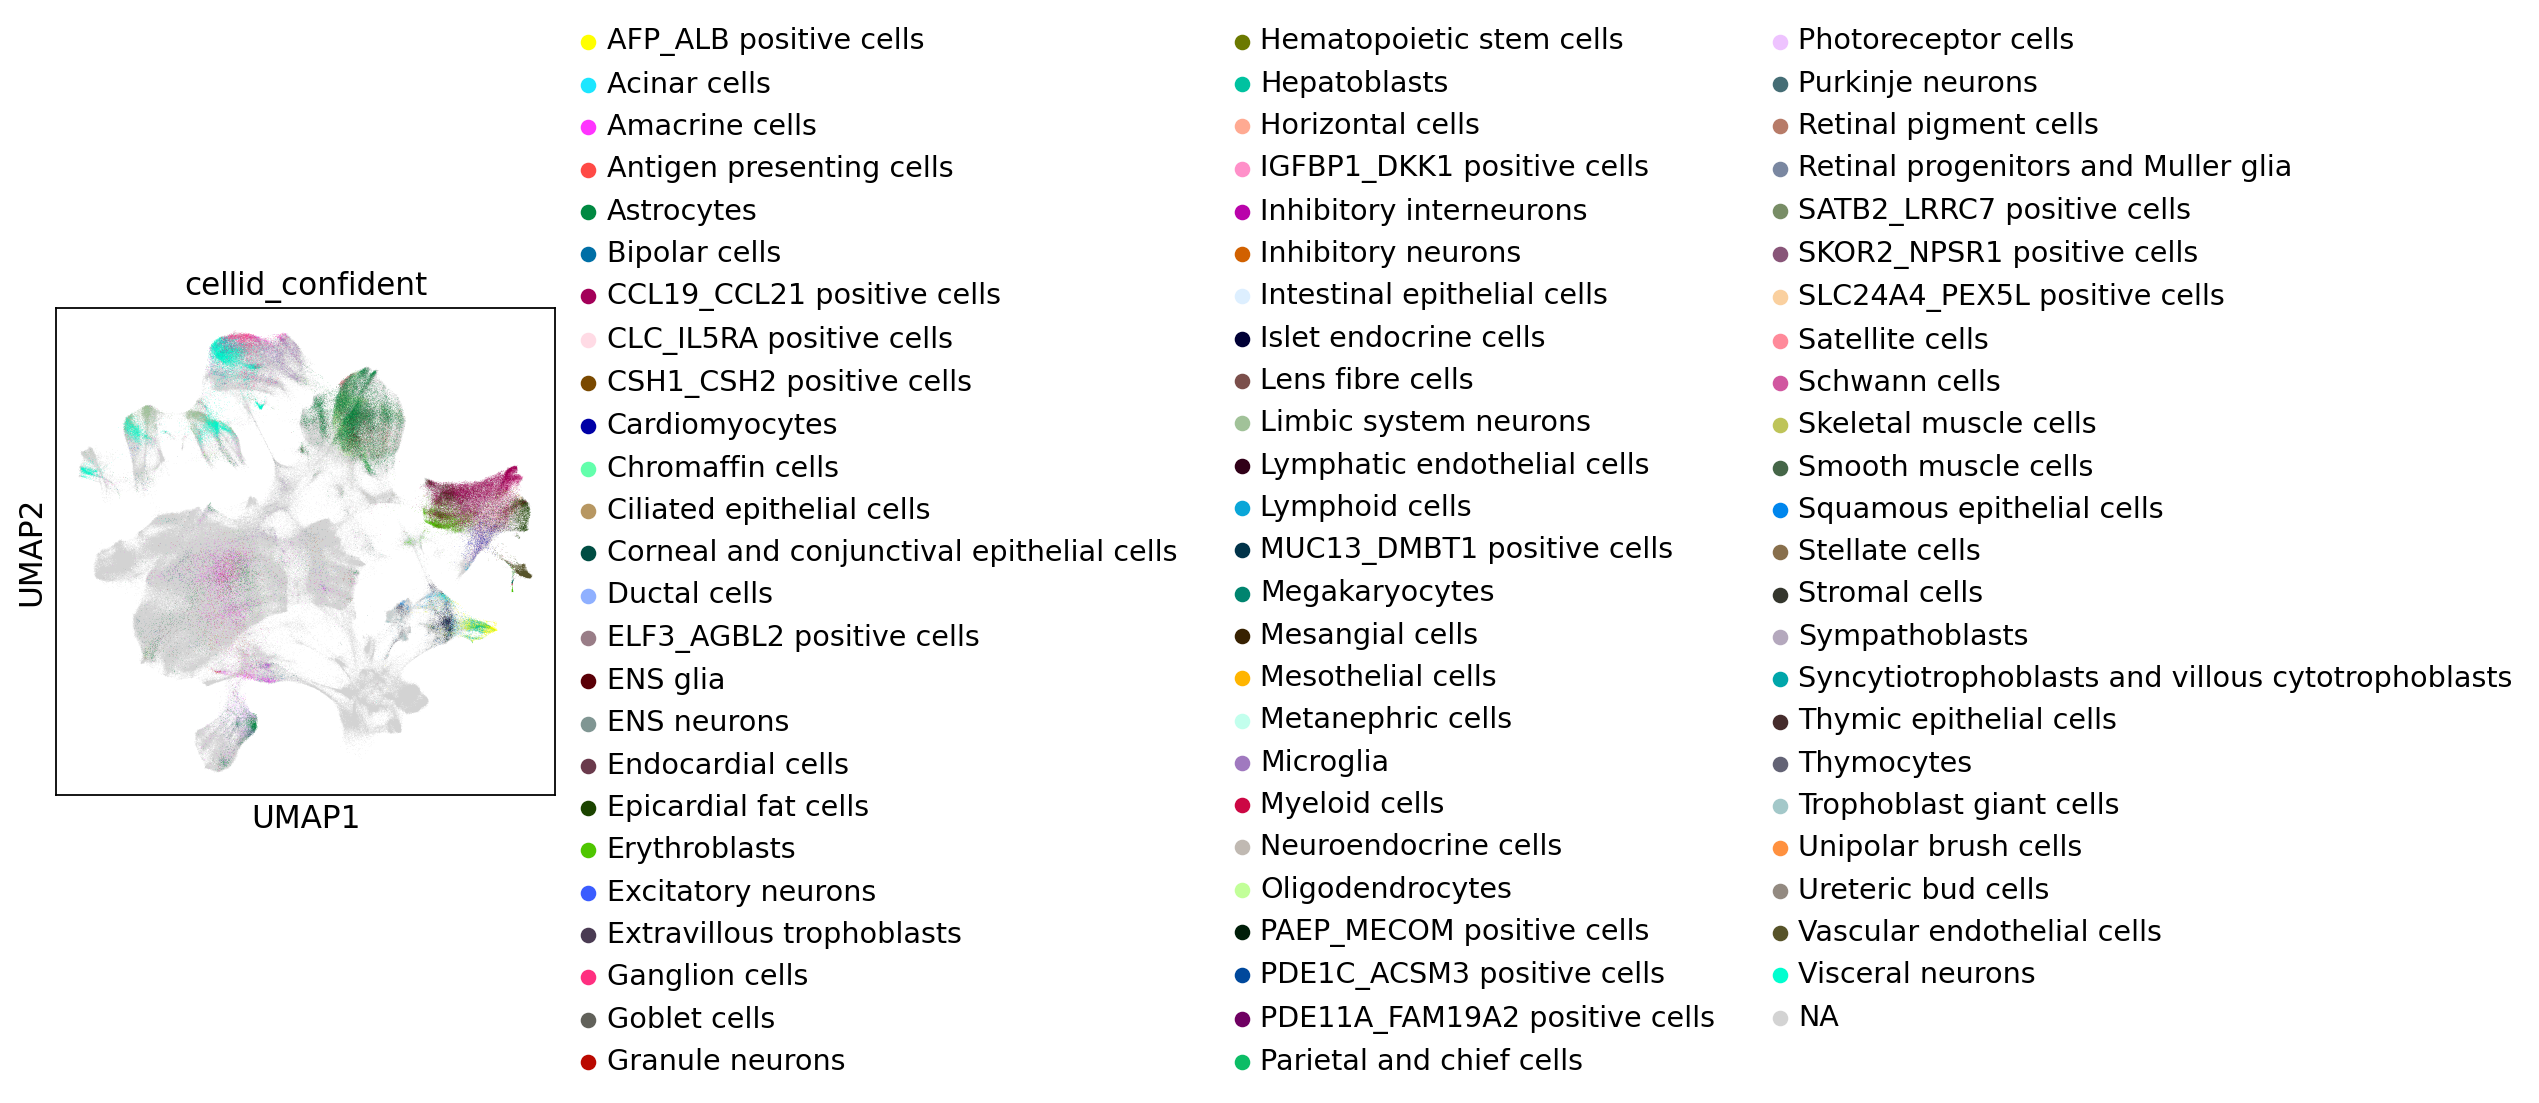

In [79]:
sc.pl.umap(adata, color='cellid_confident')

In [52]:
adata.obs['cellid_confident'].value_counts()

Astrocytes                                           24801
CCL19_CCL21 positive cells                           18102
Visceral neurons                                     14893
Oligodendrocytes                                      8645
Smooth muscle cells                                   7989
Limbic system neurons                                 6574
Amacrine cells                                        5859
Photoreceptor cells                                   5310
Erythroblasts                                         4816
Mesangial cells                                       4594
CLC_IL5RA positive cells                              4178
Ganglion cells                                        3628
Epicardial fat cells                                  3420
Vascular endothelial cells                            3289
Microglia                                             3215
AFP_ALB positive cells                                2824
IGFBP1_DKK1 positive cells                            23

In [88]:
adata.obs = adata.obs.drop(['confident_cellid', 'cellid_assignment'], 1).rename(columns={"annotated": "cellid_annotation"})

/tmp/jobs/19525810/ipykernel_173620/2832627802.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  adata.obs = adata.obs.drop(['confident_cellid', 'cellid_assignment'], 1).rename(columns={"annotated": "cellid_annotation"})


In [90]:
adata.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.h5ad")